In [340]:
import plenoptic as po
import torch
import numpy as np
# needed for the plotting/animating:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['animation.html'] = 'html5'
# use single-threaded ffmpeg for animation writer
plt.rcParams['animation.writer'] = 'ffmpeg'
plt.rcParams['animation.ffmpeg_args'] = ['-threads', '1']
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision
import einops
import matplotlib as mpl

In [341]:
def gram_matrix(x):
    a, b, c, d = x.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = x.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [423]:
class TorchVision(torch.nn.Module):
    def __init__(self, model, content_nodes: str, style_nodes: str, transform = None):
        super().__init__()
        self.transform = transform
        if not isinstance(style_nodes, list):
            style_nodes = [style_nodes]
        if not isinstance(content_nodes, list):
            content_nodes = [content_nodes]
        self.style_extractor = create_feature_extractor(model, return_nodes=style_nodes)
        self.style_nodes = style_nodes
        self.content_extractor = create_feature_extractor(model, return_nodes=content_nodes)
        self.content_nodes = content_nodes
        self.model = model
    
    def forward(self, x):
        if self.transform is not None:
            x = self.transform(x)
        if x.shape[0] == 1:
            content = self.content_extractor(x)
            style = self.style_extractor(x)
        elif x.shape[0] == 2:
            content = self.content_extractor(x[0:1])
            style = self.style_extractor(x[1:2])
        style = [gram_matrix(s)[None, None] for s in style.values()]
        t, p = einops.pack([*list(content.values()), *style], "b *")
        self.shapes = p
        return t.unsqueeze(1)
    
    def plot_representation(
        self,
        data: torch.Tensor,
        ax = None,
        figsize = (5, 5),
        ylim = None,
        batch_idx = 0,
        title = None,
    ):
        # Select the batch index
        all_tensors = einops.unpack(data[0], self.shapes, "b *")
        content_rep = all_tensors[:len(self.content_nodes)]
        style_rep = all_tensors[len(self.content_nodes):]
        
        # Determine figure layout
        axes = []
        if ax is None:
            fig = plt.figure(figsize=figsize)
            gs = mpl.gridspec.GridSpec(2, len(all_tensors), height_ratios=[3, 1])
        else:
            ax = po.tools.clean_up_axes(ax, False, ["top", "right", "bottom", "left"], ["x", "y"])
            gs = ax.get_subplotspec().subgridspec(2, len(all_tensors), height_ratios=[3, 1])
            fig = ax.figure
        
        for i, cont in enumerate(content_rep):
            ax = fig.add_subplot(gs[0, i])
            cont = cont[batch_idx].detach().cpu()      
            po.imshow(cont.abs().mean(0)[None,None], ax=ax, vrange='auto0')
            ax = fig.add_subplot(gs[1, i])
            po.tools.clean_stem_plot(cont.abs().mean((-2, -1)), ax=ax, title="Content", ylim=False)
            axes.append(ax)
        for i, style in enumerate(style_rep):
            ax = fig.add_subplot(gs[0, len(content_rep)+i])
            style = style[batch_idx].detach().cpu()
            po.imshow(style[None], ax=ax, vrange='auto0')
            axes.append(ax)

        return fig, axes

In [424]:
model = torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights.IMAGENET1K_V1)
transform = torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms()

In [425]:
train_nodes, eval_nodes = get_graph_node_names(model)

In [426]:
content_layer = "features.21" # conv4_2
style_layer = ["features.0", "features.5", "features.10", "features.19", "features.28"] # conv5_1

In [487]:
neckarfront = po.load_images("Neckarfront_Tübingen_August_2013.jpg", as_gray=False).to(0)
neckarfront = po.tools.blur_downsample(po.tools.center_crop(neckarfront, 896), 2)
vangogh = po.load_images('VanGogh-starry_night.jpg', as_gray=False).to(0)
vangogh = po.tools.blur_downsample(po.tools.center_crop(vangogh, 896), 2)
#vangogh = po.tools.blur_downsample(po.tools.center_crop(vangogh, 1024), 2)
combined = torch.cat([neckarfront, vangogh], dim=0)

In [489]:
mdl = TorchVision(model, content_layer, style_layer, transform)

In [490]:
mdl.to(0)
po.tools.remove_grad(mdl)
mdl.eval()
po.tools.validate.validate_model(mdl, device=0, image_shape=img.shape)

In [491]:
class StyleTransfer(po.synth.Metamer):
    r""" Extending metamer synthesis based on image-computable 
    differentiable models, for mixing two images.
    """
    def __init__(        
        self,
        image: torch.Tensor,
        model: torch.nn.Module,
        style_content_tradeoff: float,
        loss_function = po.tools.optim.mse,
        range_penalty_lambda: float = 0.1,
        allowed_range: tuple[float, float] = (0, 1),
    ):
        super().__init__(image, model, loss_function, range_penalty_lambda, allowed_range)
        self.style_content_tradeoff = style_content_tradeoff

    def setup(
        self,
        initial_image=None,
        optimizer=None,
        optimizer_kwargs=None,
        scheduler=None,
        scheduler_kwargs=None,
    ):
        """Initialize the metamer.

        Set the ``self.metamer`` attribute to be a parameter with
        the user-supplied data, making sure it's the right shape.

        Parameters
        ----------
        initial_image :
            The tensor we use to initialize the metamer. If None (the
            default), we initialize with uniformly-distributed random
            noise lying between 0 and 1.

        """
        if initial_image.ndimension() < 4:
            raise Exception(
                "initial_image must be torch.Size([n_batch"
                ", n_channels, im_height, im_width]) but got "
                f"{initial_image.size()}"
            )
        # the difference between this and the regular version of Metamer is that
        # the regular version requires synthesized_signal and target_signal to have
        # the same shape, and here target_signal is
        # (2, 1, 256, 256), not (1, 1, 256, 256)
        metamer = initial_image.clone().detach()
        metamer = metamer.to(dtype=self.image.dtype, device=self.image.device)
        metamer.requires_grad_()
        self._metamer = metamer
        # initialize the optimizer
        self._initialize_optimizer(optimizer, self.metamer, optimizer_kwargs)
        # and scheduler
        self._initialize_scheduler(scheduler, self.optimizer, scheduler_kwargs)
    
    def objective_function(
        self,
        metamer_representation: torch.Tensor | None = None,
        target_representation: torch.Tensor | None = None,
    ):
        if metamer_representation is None:
            metamer_representation = self.model(self.metamer)
        if target_representation is None:
            target_representation = self.target_representation
            
        all_tensors = einops.unpack(metamer_representation[0], self.model.shapes, "b *")
        content_met = all_tensors[:len(self.model.content_nodes)]
        style_met = all_tensors[len(self.model.content_nodes):]
        
        all_tensors = einops.unpack(target_representation[0], self.model.shapes, "b *")
        content_target = all_tensors[:len(self.model.content_nodes)]
        style_target = all_tensors[len(self.model.content_nodes):]
        
        content_loss = torch.stack([self.loss_function(m, t) for m, t in zip(content_met, content_target)])
        style_loss = torch.stack([self.loss_function(m, t) for m, t in zip(style_met, style_target)])
        content_loss = torch.mean(content_loss)
        style_loss = torch.mean(style_loss)
        range_penalty = po.tools.optim.penalize_range(self.metamer, self.allowed_range)
        return content_loss + self.style_content_tradeoff * style_loss + self.range_penalty_lambda * range_penalty


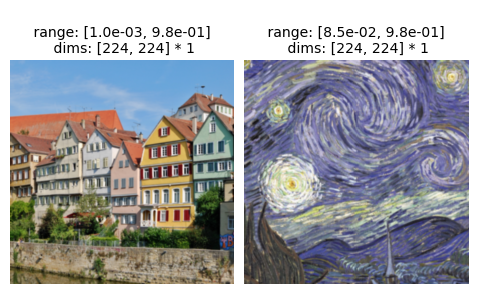

In [521]:
po.imshow(combined, as_rgb=True);

In [572]:
met = StyleTransfer(combined, mdl, 1e7)
met.setup(torch.rand_like(neckarfront), optimizer_kwargs={'lr': 1e-2})

In [573]:
met.synthesize(5000, stop_criterion=1e-8)

  0%|          | 0/5000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


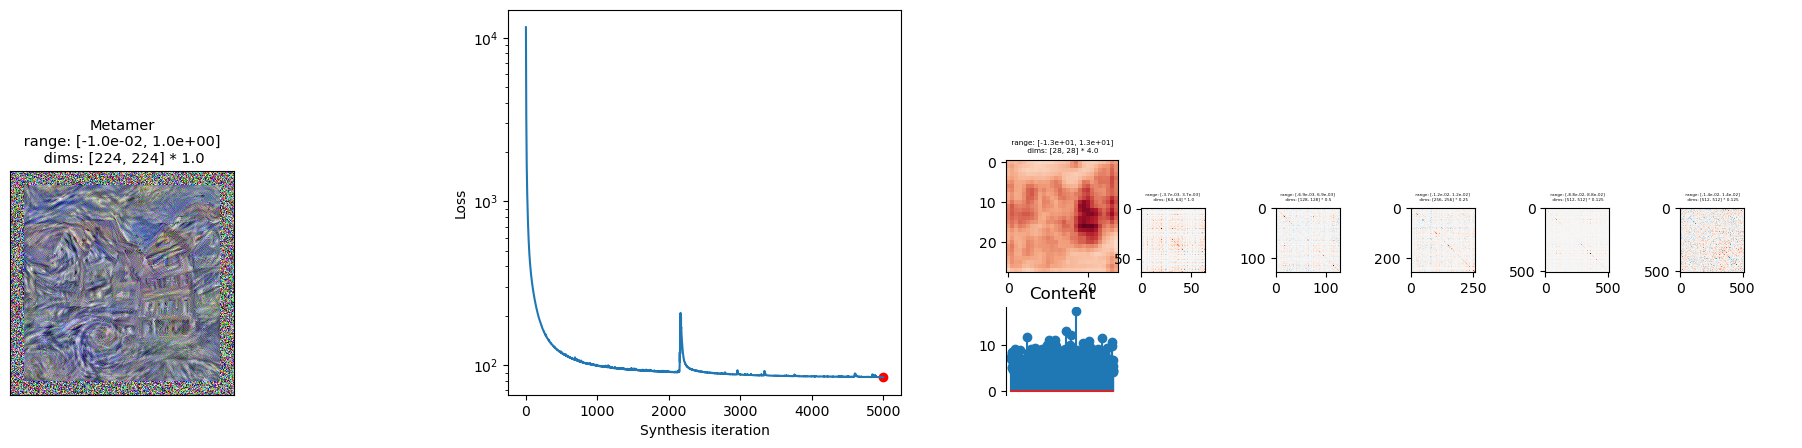

In [574]:
po.synth.metamer.plot_synthesis_status(met, ylim=False, #included_plots=["display_metamer", "plot_loss"], 
                                        width_ratios={"plot_representation_error": 2}
                                      );

In [578]:
met = StyleTransfer(combined, mdl, 1e3)
met.setup(torch.rand_like(neckarfront), optimizer_kwargs={'lr': 1e-2})

In [579]:
met.synthesize(5000, stop_criterion=1e-8)

  0%|          | 0/5000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


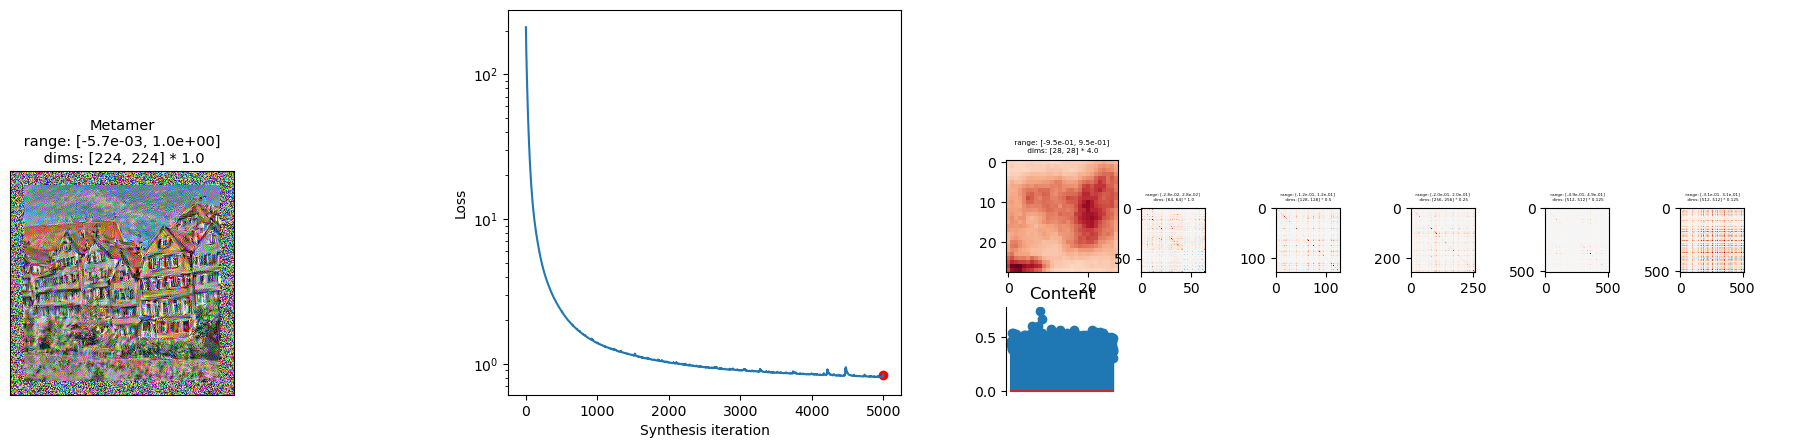

In [580]:
po.synth.metamer.plot_synthesis_status(met, ylim=False, #included_plots=["display_metamer", "plot_loss"], 
                                        width_ratios={"plot_representation_error": 2}
                                      );

In [575]:
met = StyleTransfer(combined, mdl, 1e7)
met.setup(neckarfront, optimizer_kwargs={'lr': 1e-2})

In [576]:
met.synthesize(5000, stop_criterion=1e-8)

  0%|          | 0/5000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


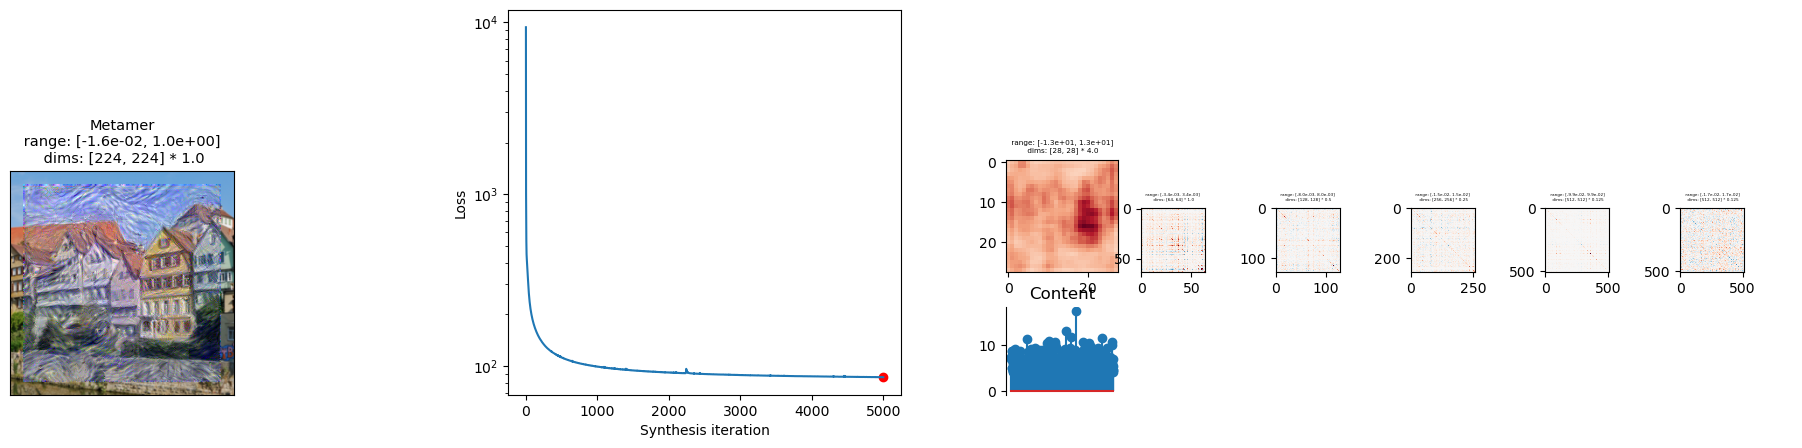

In [577]:
po.synth.metamer.plot_synthesis_status(met, ylim=False, #included_plots=["display_metamer", "plot_loss"], 
                                        width_ratios={"plot_representation_error": 2}
                                      );